In [1]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = lasio.read("R-540_NMR.las").df().dropna()
df.describe()

LAS spec version is 3.0 -- neither 1.2 nor 2


,T2DIST_DI_CMR[0],T2DIST_DI_CMR[1],T2DIST_DI_CMR[2],T2DIST_DI_CMR[3],T2DIST_DI_CMR[4],T2DIST_DI_CMR[5],T2DIST_DI_CMR[6],T2DIST_DI_CMR[7],T2DIST_DI_CMR[8],T2DIST_DI_CMR[9],...,T2DIST_DI_CMR[54],T2DIST_DI_CMR[55],T2DIST_DI_CMR[56],T2DIST_DI_CMR[57],T2DIST_DI_CMR[58],T2DIST_DI_CMR[59],T2DIST_DI_CMR[60],T2DIST_DI_CMR[61],T2DIST_DI_CMR[62],T2DIST_DI_CMR[63]
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,...,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,0.000835,0.000890,0.000910,0.000900,0.000867,0.000831,0.000812,0.000832,0.000868,0.000890,...,0.001577,0.001397,0.001252,0.001144,0.001078,0.001040,0.001017,0.001024,0.001144,0.001559
std,0.001656,0.001795,0.001870,0.001885,0.001860,0.001823,0.001819,0.001861,0.001935,0.001994,...,0.002882,0.002619,0.002397,0.002216,0.002076,0.001977,0.001910,0.001875,0.002063,0.004487
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000044,0.000134
75%,0.001019,0.001093,0.001145,0.001115,0.001143,0.001101,0.000998,0.001063,0.001163,0.001136,...,0.001787,0.001443,0.001250,0.001099,0.001102,0.001095,0.001130,0.001228,0.001397,0.001806
max,0.012909,0.014342,0.015693,0.016455,0.016569,0.016245,0.016757,0.017733,0.018616,0.019078,...,0.015088,0.012975,0.011932,0.012398,0.012861,0.013059,0.012948,0.012518,0.019735,0.097010


In [3]:
from scipy import stats
from scipy.misc import derivative
from scipy.interpolate import splrep, splev

In [4]:
class T2Dist(stats.rv_continuous):
    def __init__(self, t2_min, t2_max, bins, t2_data, clip_point=None):
        """
        Creates a continuous T2 distribution which can be sampled from
        Binned T2 data is converted to a continuous variable using a cubic spline
        :param t2_min: Min extent of T2 e.g. 0.3ms
        :param t2_max: Max extent of T2 e.g. 30000ms
        :param bins: Number of bins in the T2 distribution from the LAS file
        :param t2_data: The T2 values from the LAS file (array of len bins)
        """
        super().__init__(a=np.log10(t2_min), b=np.log10(t2_max))
        time_step = (np.log10(t2_max) - np.log10(t2_min)) / (bins - 1)
        self.log_time = [np.log10(t2_min) + x * time_step for x in range(bins)]
        if clip_point is None:
            self.t2 = t2_data
        else:
            self.t2 = self.clip_data(clip_point, t2_data)

    def _cdf(self, x, *t2_data):
        tck = splrep(self.log_time, self.t2.cumsum()/self.t2.cumsum().max())
        return splev(x, tck)

    def _pdf(self, x, *args):
        d = derivative(self._cdf, x, dx=1e-5, args=args, order=5)
        d[d < 0] = 0
        return d

    def clip_data(self, clip_point, t2_data):
        clipped_t2_data = []
        for x, y in zip(self.log_time, t2_data):
            if x < np.log10(clip_point):
                clipped_t2_data.append(1e-8)
            else:
                clipped_t2_data.append(y)
        return np.array(clipped_t2_data)

In [5]:
raw_data = df.iloc[667]

In [6]:
t2 = T2Dist(0.3, 6000, 64, raw_data)
data = t2.rvs(size=10000)

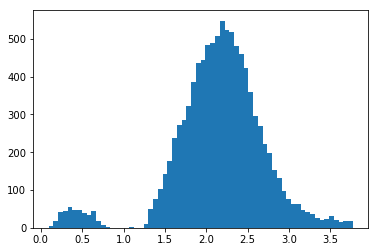

In [7]:
plt.hist(data, bins=64);

In [8]:
from sklearn.mixture import BayesianGaussianMixture

In [17]:
n = 20
gm = BayesianGaussianMixture(n_components=n, degrees_of_freedom_prior=20, max_iter=20000)
gm.fit(data.reshape(-1, 1))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=20, init_params='kmeans',
            max_iter=20000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [10]:
x_plot = np.linspace(np.log10(0.3), np.log10(6000), 200)
t2_pdf = t2.pdf(x_plot)

In [11]:
components = []
for i in range(n):
    components.append(gm.weights_[i]*stats.norm.pdf(x_plot, gm.means_[i], np.sqrt(gm.covariances_[i])).flatten())
components = np.transpose(components)

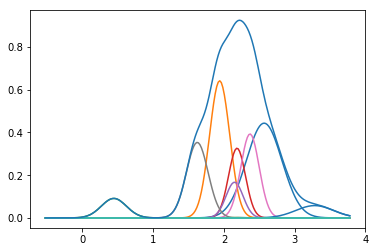

In [12]:
plt.plot(x_plot, components);
plt.plot(x_plot, np.sum(components, axis=1));

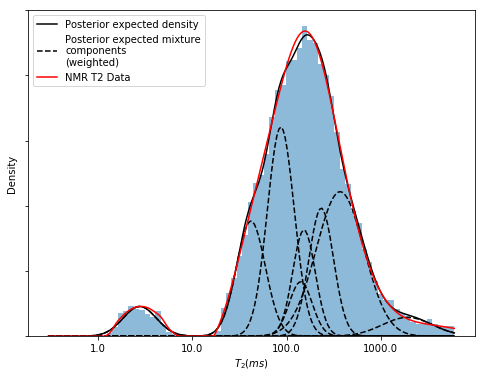

In [20]:
from collections import OrderedDict

fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.hist(data, bins=64, normed=True, lw=0, alpha=0.5)
ax3.plot(x_plot, np.sum(components, axis=1), color='k', label='Posterior expected density')
ax3.plot(x_plot, components, '--', color='k', label='Posterior expected mixture\ncomponents\n(weighted)')
ax3.plot(x_plot, t2_pdf, color='r', label="NMR T2 Data")
ax3.set_xticklabels(10 ** np.array(ax3.get_xticks().tolist()))
ax3.set_xlabel('$T_{2} (ms)$')
ax3.set_yticklabels([])
ax3.set_ylabel('Density')
ax3.legend(loc=2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [15]:
gm.weights_

array([  2.79818753e-01,   2.28504920e-01,   4.03857047e-02,
         9.73839689e-02,   5.09287733e-02,   4.80601091e-04,
         1.28057778e-01,   1.35099857e-01,   4.95315234e-04,
         4.24159376e-04,   3.84152184e-02,   4.71520341e-06,
         2.24533496e-07,   1.06920712e-08,   5.09146248e-10,
         2.42450594e-11,   1.15452664e-12,   5.49774591e-14,
         2.61797424e-15,   1.24665440e-16])

In [21]:
gm.weight_concentration_

(array([  2.37873743e+03,   1.50264349e+03,   4.85158722e+00,
          2.00986028e+03,   7.92261574e+00,   4.77863275e+00,
          4.75226694e+00,   1.39825751e+03,   1.84211511e+03,
          4.57399424e+00,   4.46888304e+00,   4.37153970e+00,
          4.39518185e+02,   4.11223093e+00,   4.04036237e+02,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([  7.62231257e+03,   6.12066907e+03,   6.11681749e+03,
          4.10795721e+03,   4.10103459e+03,   4.09725596e+03,
          4.09350369e+03,   2.69624618e+03,   8.55131070e+02,
          8.51557076e+02,   8.48088193e+02,   8.44716653e+02,
          4.06198468e+02,   4.03086237e+02,   5.00000007e-02,
          5.00000000e-02,   5.00000000e-02,   5.00000000e-02,
          5.00000000e-02,   5.00000000e-02]))